# Prediction of Nighttime NO2

## Background

### Names and Acronyms
1) ASDC: [Atmosperhic Science Data Center](https://asdc.larc.nasa.gov/about)
1) PGN (Pandora): [Pandonia Global Network](https://www.pandonia-global-network.org/) / [Pandora](https://pandora.gsfc.nasa.gov/About/)
    - **NOTE**: NASA's portion of the PGN is known as Pandora.  Within the scope of this notebook, Pandora and PGN may be used interchangably as this project will only use NASAs PGN site data.
1) TEMPO: [Troposoperic Emissions: Monitoring of Pollution](https://science.nasa.gov/mission/tempo/)

### Resources
1) ASDC Data Processing Tool (Version 1)
    - This notebook was published by the ASDC and provides examples of how to correctly load and use Pandora and TEMPO data.
    - https://github.com/nasa/ASDC_Data_and_User_Services/blob/main/TEMPO/additional_drafts/ASDC_Data_Processing_ML_v1.2.ipynb
1) PGN Station Map
    - A map showing the location of all PGN groundsites.
    - https://blickm.hetzner.pandonia-global-network.org/livemaps/pgn_stationsmap.png


This notebook borrows heavily from and extens the functionality of the NASA, ASDC Data and User Servicies notebook found here:

https://github.com/nasa/ASDC_Data_and_User_Services/blob/main/TEMPO/additional_drafts/ASDC_Data_Processing_ML_v1.2.ipynb

This notebook intends to test the hypothesis that a model can be built with Pandora which can predict nightitme NO<sub>2</sub> and that that model can be applied to TEMPO daytime measurments to predict NO<sub>2</sub> for any location covered by TEMPO.



## 1. Environment Setup

### Environment Setup
There are many tools available such as [poetry](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://python-poetry.org/&ved=2ahUKEwjr9aLgna6QAxX5EVkFHVsNBMUQFnoECBsQAQ&usg=AOvVaw3Jp8q7OO7XkcY8Tq4tDe30) and [uv](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://docs.astral.sh/uv/&ved=2ahUKEwiP9aXVna6QAxVyF1kFHeyTNGYQFnoECAsQAQ&usg=AOvVaw2VJVt0jrah2S9tIgdc1yRc) that simplify and speed up environment setup.  For simplicity, this guide only covers the method built into the python standard library.
1) Install [Python 3.11](https://www.python.org/downloads/) (or higher)
1) (Recomended) Create a virtual environment (learn more [here](https://docs.python.org/3/library/venv.html))
1) Install the required packages using the following command.<br>`% pip install pyproject.toml`
1) Select the newly created kernal in your notebook.
    - NOTE: this varies slightly between notebook tools, but in almost all tools you will be prompted to select a kernal upon running a cell.

### 1.2. Import required modules

Common imports that are used throughout.  Other packages will be imported as needed.

In [645]:
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd

### 1.3. Data Access
In order to access data, you will need an Earthdata Login account.  If you do not have an Earthdata Login account, you can create one here:<br>
https://urs.earthdata.nasa.gov/

The earthaccess module allows you to authenticate.  Multilple login options exist for providing your credentials, you can read more on options here:<br>
https://pypi.org/project/earthaccess/<br>
By unless another option is configured, you will be prompted by your notebook to enter your credentials.

In [646]:
import earthaccess


earthaccess.login()

Notebook Settings

In [647]:
PGN_DATA_DIR = Path('pgn-data')
PGN_DATA_DIR.mkdir(mode=0o777, parents=True, exist_ok=True)
PGN_DATA_PATH = PGN_DATA_DIR.joinpath('pgn-data.csv')
TEMPO_DATA_DIR = Path('tempo-data')
TEMPO_DATA_DIR.mkdir(mode=0o777, parents=True, exist_ok=True)
TEMPO_DATA_PATH = TEMPO_DATA_DIR.joinpath('tempo-data.csv')

Optionally, clean data stores, since data is filtered by time and site, data shoudl be removed when times or sites change.

In [648]:
# if CLEAN is True, removes all stored data.
CLEAN_PGN = True
CLEAN_TEMPO = False

if CLEAN_PGN:
    for file in PGN_DATA_DIR.iterdir():
        file.unlink()
if CLEAN_TEMPO:
    for file in TEMPO_DATA_DIR.iterdir():
        file.unlink()

## 2. Data Prepairation

### 2.1. Download Data

**Data Ingest Workflow**
1) Collect the URLs for relivant files.
1) If not already downloaded, download the files.
1) If not already parsed, parse the files and save them as dataframes.
1) Return a list of relivant file paths

**Notes**
- PGN and TEMPO files are saved to the PGN_DATA_DIR and TEMPO_DATA_DIR directories.
- This system allows new files to be added while old files are still used, when available.
- TEMPO files are VERY large, a full year of data for 3 PGN sites takes up 100GB of hard drive space.
- Running for a shorter time period does not delete data, it only uses a smaller subset of files ensuring that short time frames can be used for testing.
- Though VERY slow to run initially, subsiquent runs for the same or smaller data subsets are fairly fast.

#### 2.1.1. Define Download Settings

In [649]:
# July 21, 2024 was a full moon, which should provide high quality Lunar PGN NO2 Readings.
start_date = datetime(2024, 7, 15)
end_date = datetime(2024, 7, 25)

#### 2.1.2. Get Pandora data

Pandora settings

You can find all Pandora daytime data [here](https://data.pandonia-global-network.org), nighttime data must be acquired from the [API](https://api.hetzner.pandonia-global-network.org/docs#/).

For more information about PGN codes and columns, see the file header.

In [650]:
daytime_suffix = 'rnvh3p1-8.txt'
nightitme_suffix = 'rnvm2p1-8.txt'
pgn_formats = {
    # daytime file format
    daytime_suffix: {
        'cycle': 'Day',
        'suffix': 'rnvh3p1-8.txt',
        'no2_quality_flag_index': 52,
        'valid_quality_flags': [0, 10],
        'column_index': 61,
        'column_unc_index': 62,
    },
    # nighttime file format
    nightitme_suffix: {
        'cycle': 'Night',
        'suffix': 'rnvm2p1-8.txt',
        'no2_quality_flag_index': 35,
        'valid_quality_flags': [0, 1, 10, 11, 12],
        'column_index': 38,
        'column_unc_index': 39,
    },
}

# sites = ['BronxNY', 'BuffaloNY', 'QueensNY']
# site with known daytime and nighttime data
sites = {'WashingtonDC', 'HamptonVA'}

An API must be used to download the daytime and nighttime files where they exist.  Not all sites are set up to take nighttime readings.

You can read more about the API here:<br>
https://api.hetzner.pandonia-global-network.org/docs#/v1%2Ffiles/location_v1_files__location__get

For each location, search each instrument and spectrometer for applicable files.

In [651]:
import requests


BASE_URL = "https://api.ovh.pandonia-global-network.org/v1/files"
headers = {"X-API-Key": "kWKkafU6BfyO9vGQbso_o-LZYOZTL6IOaFLtdj8dIpQ"}  # Add your API key here

pgn_urls: list[str] = []
for s, site in enumerate(sites):
    print("Processing site", s+1, 'of', len(sites), site)
    instruments = requests.get(f"{BASE_URL}/{site}",  headers=headers).json()
    for i, instrument in enumerate(instruments):
        print("\tProcessing instrument", i+1, 'of', len(instruments), instrument)
        instrument_id = instrument['pan_id']
        for s, spectrometer in enumerate([1, 2]):
            print("\t\tProcessing spectrometer", s+1, 'of', 2, spectrometer)
            for c, code in enumerate(['rnvm2', 'rnvh3']):
                print("\t\t\tProcessing ocde", c+1, 'of', 2, code)
                url = (
                    'https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?'
                    f'start_datetime={start_date.date()}&'
                    f'end_datetime={end_date.date()}&'
                    f'pan_id={instrument_id}&'
                    f'spectrometer={spectrometer}&'
                    f'location={site}&'
                    f'code={code}&blickp_version=p1-8'
                )
                response = requests.get(url, headers=headers).content.decode('utf-8')
                if response.startswith('File name:'):
                    print("\t\t\t\tFile Found")
                    pgn_urls.append(url)
pgn_urls

Processing site 1 of 2 WashingtonDC
	Processing instrument 1 of 1 {'pan_id': 140}
		Processing spectrometer 1 of 2 1
			Processing ocde 1 of 2 rnvm2
				File Found
			Processing ocde 2 of 2 rnvh3
				File Found
		Processing spectrometer 2 of 2 2
			Processing ocde 1 of 2 rnvm2
			Processing ocde 2 of 2 rnvh3
Processing site 2 of 2 HamptonVA
	Processing instrument 1 of 4 {'pan_id': 32}
		Processing spectrometer 1 of 2 1
			Processing ocde 1 of 2 rnvm2
			Processing ocde 2 of 2 rnvh3
		Processing spectrometer 2 of 2 2
			Processing ocde 1 of 2 rnvm2
			Processing ocde 2 of 2 rnvh3
	Processing instrument 2 of 4 {'pan_id': 37}
		Processing spectrometer 1 of 2 1
			Processing ocde 1 of 2 rnvm2
			Processing ocde 2 of 2 rnvh3
				File Found
		Processing spectrometer 2 of 2 2
			Processing ocde 1 of 2 rnvm2
			Processing ocde 2 of 2 rnvh3
	Processing instrument 3 of 4 {'pan_id': 38}
		Processing spectrometer 1 of 2 1
			Processing ocde 1 of 2 rnvm2
			Processing ocde 2 of 2 rnvh3
		Processing

['https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?start_datetime=2024-07-15&end_datetime=2024-07-25&pan_id=140&spectrometer=1&location=WashingtonDC&code=rnvm2&blickp_version=p1-8',
 'https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?start_datetime=2024-07-15&end_datetime=2024-07-25&pan_id=140&spectrometer=1&location=WashingtonDC&code=rnvh3&blickp_version=p1-8',
 'https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?start_datetime=2024-07-15&end_datetime=2024-07-25&pan_id=37&spectrometer=1&location=HamptonVA&code=rnvh3&blickp_version=p1-8']

Download files

In [652]:
# The raw PGN files
pgn_files = []
for url in pgn_urls:
    print("Processing", url)
    data = requests.get(url, headers=headers).content.decode('utf-8')
    first_line = data.split('\n', 1)[0]
    file_name = first_line.split(': ')[-1]
    # remove random code from end of file name
    file_name = "_".join(file_name.split('_')[:-1])+'.txt'
    file_path = PGN_DATA_DIR.joinpath(file_name)
    pgn_files.append(file_path)
    if file_path.exists():
        print("File exists:", file_path)
        continue
    file_path.write_text(data)
    print("File saved:", file_path)

Processing https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?start_datetime=2024-07-15&end_datetime=2024-07-25&pan_id=140&spectrometer=1&location=WashingtonDC&code=rnvm2&blickp_version=p1-8
File saved: pgn-data\Pandora140s1_WashingtonDC_L2_rnvm2p1-8.txt
Processing https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?start_datetime=2024-07-15&end_datetime=2024-07-25&pan_id=140&spectrometer=1&location=WashingtonDC&code=rnvh3&blickp_version=p1-8
File saved: pgn-data\Pandora140s1_WashingtonDC_L2_rnvh3p1-8.txt
Processing https://api.ovh.pandonia-global-network.org/v1/download/bulk_l2/official?start_datetime=2024-07-15&end_datetime=2024-07-25&pan_id=37&spectrometer=1&location=HamptonVA&code=rnvh3&blickp_version=p1-8
File saved: pgn-data\Pandora37s1_HamptonVA_L2_rnvh3p1-8.txt


Parse files into CSV format (if needed)

In [653]:
# PGN format settings (these should not change)
pgn_section_delim = f"{'-'*87}\n"
header_delim = ": "
pgn_loc_key = "Short location name"
pgn_lat_key = "Location latitude [deg]"
pgn_lon_key = "Location longitude [deg]"
# Avogadro constant divided by 10000
no2_scale = 6.02214076E+19

_sites = []
lats = []
lons = []
# the PGN dat parsed into CSV files
PGN_PATHS = []

# build the final dataset
print("Parsing PGN data started")
for i, pgn_path in enumerate(pgn_files):
    print("Processing", pgn_path)
    # get file sections as lines
    text = pgn_path.read_text()
    metadata_text, column_text, data_text = text.split(pgn_section_delim)
    metadata_lines = metadata_text.splitlines()
    data_lines = data_text.splitlines()

    # get metadata
    metadata = {}
    for line in metadata_lines:
        key, value = line.split(header_delim)
        metadata[key] = value
    
    site_lat = float(metadata[pgn_lat_key])
    site_lon = float(metadata[pgn_lon_key])
    
    _sites.append(pgn_path.name.split('_')[1])
    lats.append(site_lat)
    lons.append(site_lon)

    # if data already exists as CSV, skip parsing
    csv_path = pgn_path.with_suffix('.csv')
    if csv_path.exists():
        print("\tFile already parsed, skipping")
        PGN_PATHS.append(csv_path)
        continue

    # get data
    file_suffix = pgn_path.name.split('_')[-1]
    file_format = pgn_formats[file_suffix]
    no2_quality_flag_index = file_format['no2_quality_flag_index']
    valid_quality_flags = file_format['valid_quality_flags']
    column_index = file_format['column_index']
    unc_index = file_format['column_unc_index']

    rows = []
    for line in data_lines:
        values = line.split()
        # convert timestamps
        timestamp = datetime.fromisoformat(values[0]).replace(tzinfo=None)

        # filtering low quality records
        if int(values[no2_quality_flag_index]) not in valid_quality_flags:
            continue

        row = {
            'Time': timestamp,
            'Latitude': site_lat,
            'Longitude': site_lon,
            'Column': float(values[column_index])*no2_scale,
            'Uncertainty': float(values[unc_index])*no2_scale,
            'Site': metadata[pgn_loc_key],
            'Cycle': file_format['cycle']
        }
        rows.append(row)

    # convert rows into a dataframe
    if rows:
        df = pd.DataFrame(rows)
        df.to_csv(csv_path, index=False)
        PGN_PATHS.append(csv_path)
        print(f"\tValid Observations: {len(rows)}")
    else:
        print("\tWARNING: No rows in file, skipping.")

# create site metadata dataframe
sites_df = pd.DataFrame({
    'Site': _sites,
    'Latitude': lats,
    'Longitude': lons
}).set_index('Site').drop_duplicates()

print("Parsed", len(PGN_PATHS), "PGN files")
sites_df


Parsing PGN data started
Processing pgn-data\Pandora140s1_WashingtonDC_L2_rnvm2p1-8.txt
	Valid Observations: 999
Processing pgn-data\Pandora140s1_WashingtonDC_L2_rnvh3p1-8.txt
	Valid Observations: 524
Processing pgn-data\Pandora37s1_HamptonVA_L2_rnvh3p1-8.txt
Parsed 2 PGN files


,Latitude,Longitude
Site,,
WashingtonDC,38.9218,-77.0124
HamptonVA,37.1036,-76.3868


Get latitudes and longitudes (for use with TEMPO download)

#### 2.1.3. Get TEMPO Data

Get relivant TEMPO files.

In [654]:
short_name = 'TEMPO_NO2_L2' # collection name to search for in the EarthData
out_Q = 'NO2_trop_col_day'
version = 'V03'

cloud_files = []
for site, site_lat, site_lon in sites_df.itertuples():
    cloud_files += earthaccess.search_data(
        short_name = short_name,
        version = version,
        temporal = (start_date, end_date),
        point = (site_lon, site_lat)
    )

print("Found", len(cloud_files), "data collections containing the sites.")

Found 244 data collections containing the sites.


Download files (if needed)

In [655]:
import warnings

# this error comes from netCDF4 and is only a warning and can be ignored
warnings.filterwarnings(
    "ignore",
    message="__array__ implementation doesn't accept a copy keyword",
    category=DeprecationWarning,
)

nc_paths: list[Path] = []
for i, cloud_file in enumerate(cloud_files):
    # download files if a file with the same name is not found in the download directory
    paths = earthaccess.download(cloud_file, local_path=TEMPO_DATA_DIR, show_progress=False)
    nc_paths += paths

print("Downloaded", len(nc_paths), "files.")

Downloaded 244 files.


Parse TEMPO files into feather format (if needed).  This was originally CSV, but changed due to file size and speed issues.

In [656]:
import netCDF4 as nc


# only keep measurments within offset of a site
offset = 0.1

TEMPO_FILES = []
col_names = ['Time', 'Latitude', 'Longitude', 'Column', 'Uncertainty', 'Site', 'System']

for path in nc_paths:
    feather_path = path.with_suffix('.feather')
    # skip if file already exists
    if feather_path.exists():
        TEMPO_FILES.append(feather_path)
        continue

    file_time = datetime.fromisoformat(path.name.split('_')[4]).replace(tzinfo=None)
    with nc.Dataset(path) as ds:
        geolocation = ds['geolocation']
        product = ds['product']
        col_var = product['vertical_column_troposphere']
        unc_var = product['vertical_column_troposphere_uncertainty']

        col_fil = col_var.getncattr('_FillValue')
        unc_fil = unc_var.getncattr('_FillValue')

        lats = np.array(geolocation['latitude']).flatten()
        lons = np.array(geolocation['longitude']).flatten()
        cols = np.array(col_var).flatten()
        uncs = np.array(unc_var).flatten()

    num_records = len(lats)
    times = np.full((num_records), fill_value=file_time)
    systems = np.full((num_records), fill_value='TEMPO')

    data = {
        'Time': times,
        'Latitude': lats,
        'Longitude': lons,
        'Column': cols,
        'Uncertainty': uncs,
    }
    df = pd.DataFrame(data) \
        .replace({'Column': col_fil, 'Uncertainty': unc_fil}, np.nan) \
        .dropna(subset=['Column', 'Uncertainty'])
    df.to_feather(feather_path)
    TEMPO_FILES.append(feather_path)

print("Parsed", len(TEMPO_FILES), "files.")

Parsed 244 files.


PGN_FILES and TEMPO_FILES have been populdated with analysis ready data.

### 2.2. Explore and Clean Data

After download, analysis ready data must be loaded from CSVs into TEMPO and PGN data dataframs.  Once in dataframes, data can be explored, cleaned, and transformed to ready it for modeling.

#### 2.2.1. Load, Explore, and Clean Pandora

Load Pandora Data

In [657]:
pgn_df = pd.concat([pd.read_csv(p, parse_dates=['Time']) for p in PGN_PATHS], ignore_index=True).set_index("Time")
print("PGN Data Shape:", pgn_df.shape)
pgn_df.sample(5)

PGN Data Shape: (1523, 6)


,Latitude,Longitude,Column,Uncertainty,Site,Cycle
Time,,,,,,
2024-07-21 03:16:16.700,38.9218,-77.0124,1.729800e+16,1.229480e+15,WashingtonDC,Night
2024-07-16 02:37:22.400,38.9218,-77.0124,1.847653e+16,9.155461e+14,WashingtonDC,Night
2024-07-22 02:17:57.200,38.9218,-77.0124,8.563484e+15,1.358896e+15,WashingtonDC,Night
2024-07-22 06:37:33.900,38.9218,-77.0124,1.240320e+16,5.127732e+14,WashingtonDC,Night
2024-07-21 02:47:13.200,38.9218,-77.0124,-3.919089e+16,3.438040e+12,WashingtonDC,Night


Explore Data

In [658]:
print("Start Time:", pgn_df.index.min())
print("End Time:", pgn_df.index.max())
pgn_df.describe()

Start Time: 2024-07-15 00:31:15.100000
End Time: 2024-07-24 22:09:30.900000


,Latitude,Longitude,Column,Uncertainty
count,1.523000e+03,1.523000e+03,1.523000e+03,1.523000e+03
mean,3.892180e+01,-7.701240e+01,-5.693948e+117,6.594117e+18
std,7.107761e-15,1.421552e-14,5.527805e+118,4.479260e+20
min,3.892180e+01,-7.701240e+01,-5.419927e+119,-5.419927e+20
25%,3.892180e+01,-7.701240e+01,1.875144e+15,3.826920e+13
50%,3.892180e+01,-7.701240e+01,5.862494e+15,7.737246e+13
75%,3.892180e+01,-7.701240e+01,1.242940e+16,8.683325e+14
max,3.892180e+01,-7.701240e+01,1.634108e+19,1.731125e+22


First we'll need to filter data by the sptaial (lat/lon) and temporal (time) range.  The sptial range should be fine since data are tied to ground sites, while the time range covers a far longer time period than we're looking at here.

**Future Work**<br>
- Since the dataset is relatively small, consider building a model based on the entire dataset for the desired sites, then only download TEMPO data for the desired days.

Temporal Filtering

In [659]:
temporal_mask = (start_date < pgn_df.index) & (pgn_df.index < end_date)
pgn_df = pgn_df[temporal_mask]
print("Start Time:", pgn_df.index.min())
print("End Time:", pgn_df.index.max())
pgn_df.describe()

Start Time: 2024-07-15 00:31:15.100000
End Time: 2024-07-24 22:09:30.900000


,Latitude,Longitude,Column,Uncertainty
count,1.523000e+03,1.523000e+03,1.523000e+03,1.523000e+03
mean,3.892180e+01,-7.701240e+01,-5.693948e+117,6.594117e+18
std,7.107761e-15,1.421552e-14,5.527805e+118,4.479260e+20
min,3.892180e+01,-7.701240e+01,-5.419927e+119,-5.419927e+20
25%,3.892180e+01,-7.701240e+01,1.875144e+15,3.826920e+13
50%,3.892180e+01,-7.701240e+01,5.862494e+15,7.737246e+13
75%,3.892180e+01,-7.701240e+01,1.242940e+16,8.683325e+14
max,3.892180e+01,-7.701240e+01,1.634108e+19,1.731125e+22


Check for missing values

In [660]:
pgn_df.isna().sum()

Latitude       0
Longitude      0
Column         0
Uncertainty    0
Site           0
Cycle          0
dtype: int64

There's no missing data to drop.  Next we'll look at the data.

<Axes: xlabel='Time (UTC)', ylabel='NO2 Vertical Column Troposphere'>

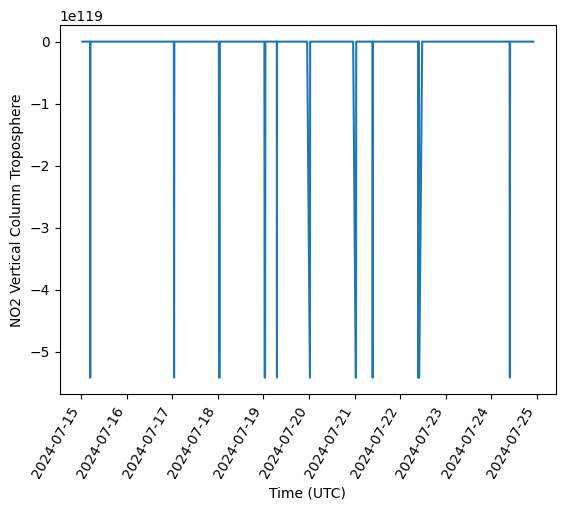

In [661]:
from matplotlib import pyplot as plt
import seaborn as sns


plt.xticks(rotation=60, ha='right')
plt.title = "Pandora NO2 Vertical Column Troposphere vs Time"
plt.xlabel('Time (UTC)')
plt.ylabel("NO2 Vertical Column Troposphere")
sns.lineplot(data=pgn_df, x='Time', y='Column')

Lets remove negative values, they seem to be otuliers.

<Axes: xlabel='Time (UTC)', ylabel='NO2 Vertical Column Troposphere'>

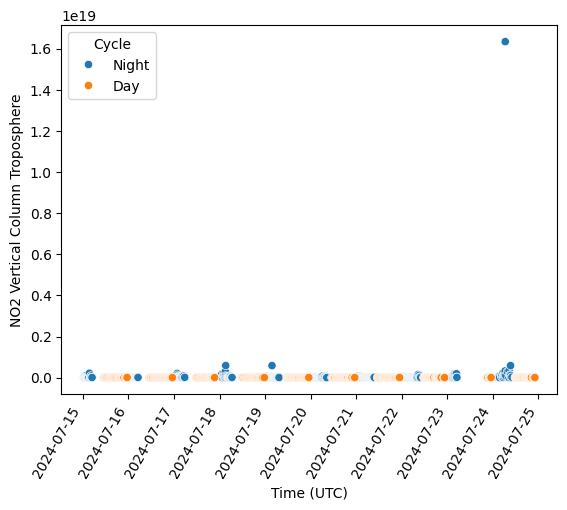

In [662]:
negative_filter = pgn_df.Column > 0
pgn_df = pgn_df[negative_filter]

fig, ax = plt.subplots()
plt.xticks(rotation=60, ha='right')
plt.title = "Pandora NO2 Vertical Column Troposphere vs Time"
plt.xlabel('Time (UTC)')
plt.ylabel("NO2 Vertical Column Troposphere")
sns.scatterplot(data=pgn_df, x='Time', y='Column', hue='Cycle')

There's a max value that is likely meaningless and would skew even an outlier calculation.

<Axes: xlabel='Time (UTC)', ylabel='NO2 Vertical Column Troposphere'>

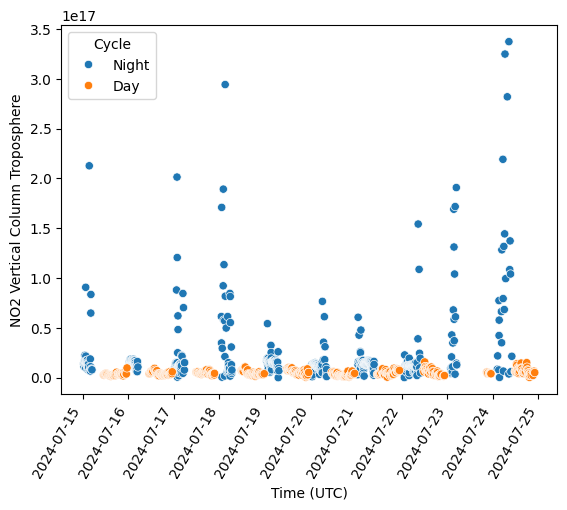

In [663]:
max_filter = pgn_df.Column < 4e17
pgn_df = pgn_df[max_filter]

fig, ax = plt.subplots()
plt.xticks(rotation=60, ha='right')
plt.title = "Pandora NO2 Vertical Column Troposphere vs Time"
plt.xlabel('Time (UTC)')
plt.ylabel("NO2 Vertical Column Troposphere")
sns.scatterplot(data=pgn_df, x='Time', y='Column', hue='Cycle')

It seems that the outliers of nighttime and daytime data are on vary different scales.  Lets calculate and remove outliers on a per dataset basis.

<Axes: xlabel='Time (UTC)', ylabel='NO2 Vertical Column Troposphere'>

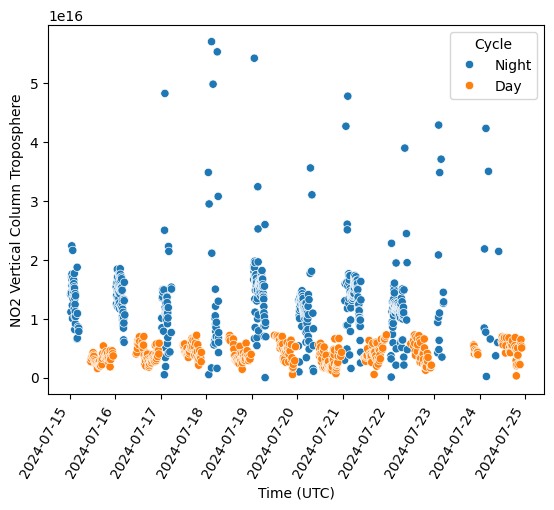

In [664]:
from matplotlib import pyplot as plt


# 3, 2, and 1 were tried, 1 offered the best results
outlier_stds = 1

# get daytime mask
day_mask = pgn_df.Cycle == 'Day'
night_mask = pgn_df.Cycle == 'Night'

day_mean = pgn_df[day_mask].Column.mean()
day_std = pgn_df[day_mask].Column.std()
day_cutoff = day_mean + (day_std * outlier_stds)
day_outlier_mask = night_mask | (pgn_df.Column < day_cutoff)

night_mean = pgn_df[night_mask].Column.mean()
night_std = pgn_df[night_mask].Column.std()
night_cutoff = night_mean + (night_std * outlier_stds)
night_outlier_mask = day_mask | (pgn_df.Column < night_cutoff)

outlier_mask = day_outlier_mask & night_outlier_mask

pgn_df = pgn_df[outlier_mask]

fig, ax = plt.subplots()
plt.xticks(rotation=60, ha='right')
plt.title = "Pandora NO2 Vertical Column Troposphere vs Time"
plt.xlabel('Time (UTC)')
plt.ylabel("NO2 Vertical Column Troposphere")
sns.scatterplot(data=pgn_df, x='Time', y='Column', hue='Cycle')

Here, we see somewhat consistant coverage over the day.  Unfortunatly, since Lunear NO2 readings require moon visability, the quality, quantity, and coverage of nightitme readings varies significantly.  

To better understand the cyclical nature of the data, lets try plotting vs time of day, effectivly overlaying one day on top of the next to see if this helps to show the day night cycle trend.

<Axes: xlabel='Hour of Day (ET)', ylabel='NO2 Vertical Column Troposphere'>

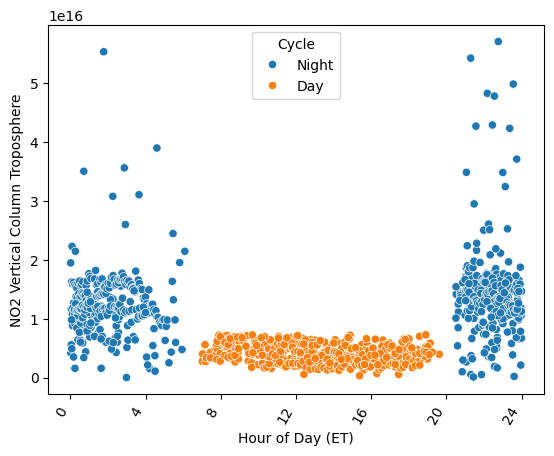

In [665]:
# convert to seconds since the linux epoch then get the remainder after deviding the seconds in a day to get time of day in seconds
pgn_df['TimeOfDay'] = (pgn_df.index.astype(int) / 10**9) % 86400
pgn_df['MinOfDay'] = pgn_df['TimeOfDay'] / 60
pgn_df['HourOfDay'] = pgn_df['MinOfDay'] / 60
# convert to Eastern Time to make them easier to read
pgn_df['HourET'] = (pgn_df['HourOfDay'] - 4) % 24

fig, ax = plt.subplots()
plt.xticks(ticks=range(0, 25, 4), rotation=60, ha='right')
plt.title = "Pandora NO2 Vertical Column Troposphere vs Time of Day"
plt.xlabel('Hour of Day (ET)')
plt.ylabel("NO2 Vertical Column Troposphere")
sns.scatterplot(data=pgn_df, x='HourET', y='Column', hue='Cycle')

Analysis

You an see that NO2 readings are lower between 7AM and 8PM, be telling of a data processing issue, but this notebok is meant to present a methodology for studying NO2 lifecycle and corrections may need to be made.  Lower, consistant values durring the day may be due to the fact that fewer cards are dirven durring day time.  NO2 builds up from 6-8 and then dies off overnight by the morning.  

It's also worth nothing that there are also some deadspots in the data where the sun and moon were not bright enough to provide a reading and depending on the moon cycle of the time frame chosen, there may not be any nighttime measruments available.

#### 2.2.2 Load, Explore and Clean TEMPO

In [666]:
# read in the files
from datetime import timedelta


tempo_df = pd.concat([pd.read_feather(p) for p in TEMPO_FILES], ignore_index=True)

# removed negative values
tempo_df = tempo_df[0 < tempo_df.Column]

# remove outliers (+/- standard deviation)
cutoff = tempo_df.Column.std() * 3
tempo_mean =  tempo_df.Column.mean()
upper_cutoff = tempo_mean + cutoff
lower_cutoff = tempo_mean - cutoff
tempo_df = tempo_df[(lower_cutoff < tempo_df.Column) & (tempo_df.Column < upper_cutoff)]

# sort by time
tempo_df.sort_values('Time', inplace=True)

# downsample to reduce data size to improve local performance.  
# We'll use hourly since TMEPO takes hourly samples.
# If sites are not close to each other, you'd want to downsample on a per site basis.
tempo_df = tempo_df.set_index('Time').resample(timedelta(hours=1)).mean()

print("TEMPO Data Shape:", tempo_df.shape)
tempo_df.head()

TEMPO Data Shape: (205, 4)


,Latitude,Longitude,Column,Uncertainty
Time,,,,
2024-07-15 10:00:00,38.062096,-77.402489,2.173043e+15,8.887786e+14
2024-07-15 11:00:00,34.870258,-78.138901,1.968157e+15,8.863915e+14
2024-07-15 12:00:00,34.968994,-78.171448,1.672219e+15,9.908314e+14
2024-07-15 13:00:00,34.962788,-78.190781,1.493042e+15,1.009291e+15
2024-07-15 14:00:00,34.992012,-78.220879,1.302972e+15,1.044253e+15


<Axes: xlabel='Time (UTC)', ylabel='NO2 Vertical Column Troposphere'>

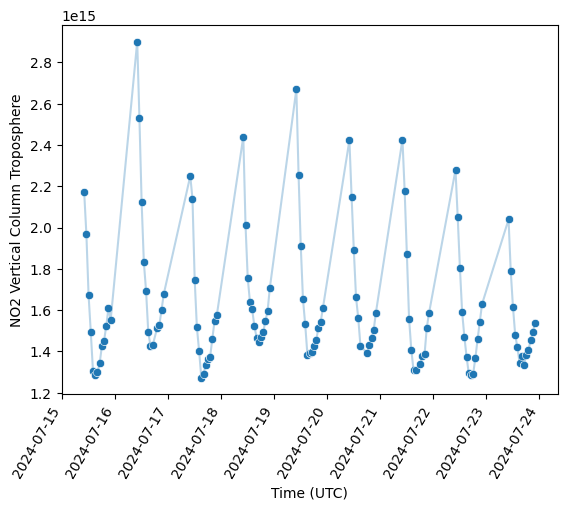

In [667]:
fig, ax = plt.subplots()
plt.xticks(rotation=60, ha='right')
plt.title = "TEMPO NO2 Vertical Column Troposphere vs Time of Day"
plt.xlabel('Time (UTC)')
plt.ylabel("NO2 Vertical Column Troposphere")
sns.scatterplot(data=tempo_df, x='Time', y='Column')
sns.lineplot(data=tempo_df, x='Time', y='Column', alpha=0.3)

Analysis:

Here, we can see that there's hourly data missing every day, represented by a steep, upward straight line each day.  It can be seen that the start of a day is very high and the end of the day cycle is much lower.  This means that there's some sort of an upward trend, likely a peak connecting the end of the day and start of the night cycle.  This is the area of intrest for this project.

In [668]:
pgn_df[['Column']].describe().join(tempo_df[['Column']].describe(), lsuffix="PGN", rsuffix="TEMPO").sort_index(axis=1)

,ColumnPGN,ColumnTEMPO
count,1.049000e+03,1.130000e+02
mean,9.418709e+15,1.623518e+15
std,6.896624e+15,3.303251e+14
min,6.042014e+11,1.273112e+15
25%,4.062115e+15,1.407275e+15
50%,8.417748e+15,1.516409e+15
75%,1.351188e+16,1.677425e+15
max,5.700318e+16,2.900628e+15


Analysis:

Although there's more PGN data, they are in the same order of magnitdue.  PGN values seem to have a higher mean and standard deviation than TMEPO.  For now I will just use a mix of TEMPO and PGN data to train a model.

**Future Work**
- Investigate why these numbers are different, is it just the sensors, is the difference neglidgable or statistically significant?
- Use a simple algorithm such as regression or random forest to map TEMPO values into PGN ranged values.
- When standardized, do the two dataset align?
- Use a bigger dataset so that that month can be used as a feature.

Next, we'll extract a time of day column, similar to that in PGN.

<Axes: xlabel='Hour of Day (ET)', ylabel='NO2 Vertical Column Troposphere'>

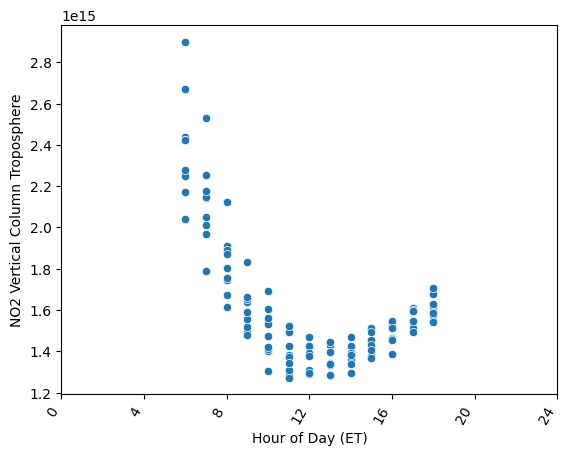

In [669]:
# convert to seconds since the linux epoch then get the remainder after deviding the seconds in a day to get time of day in seconds
tempo_df['TimeOfDay'] = (tempo_df.index.astype(int) / 10**9) % 86400
tempo_df['MinOfDay'] = tempo_df['TimeOfDay'] / 60
tempo_df['HourOfDay'] = tempo_df['MinOfDay'] / 60
# convert to Eastern Time to make them easier to read
tempo_df['HourET'] = (tempo_df['HourOfDay'] - 4) % 24

fig, ax = plt.subplots()
plt.xticks(ticks=range(0, 25, 4), rotation=60, ha='right')
plt.xlim(0, 24)
plt.title = "TEMPO NO2 Vertical Column Troposphere vs Time of Day"
plt.xlabel('Hour of Day (ET)')
plt.ylabel("NO2 Vertical Column Troposphere")
sns.scatterplot(data=tempo_df, x='HourET', y='Column')

**Analysis**<br>
We can see that column values range appears to be in roughly the same order of magnatude as the Pandora day observations.  We can also see a steep drop off around 8 AM and a steep rise around 6PM, which may match the much higher nighttime values observed in Pandora.

Finally, lets compare the TEMPO and Pandora daytime observations on the same chart to ensure they can be used togather.

C:\Users\natha\AppData\Local\Temp\ipykernel_4916\891827584.py:14: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(pgn_df['HourET'], pgn_df.Column, degree)


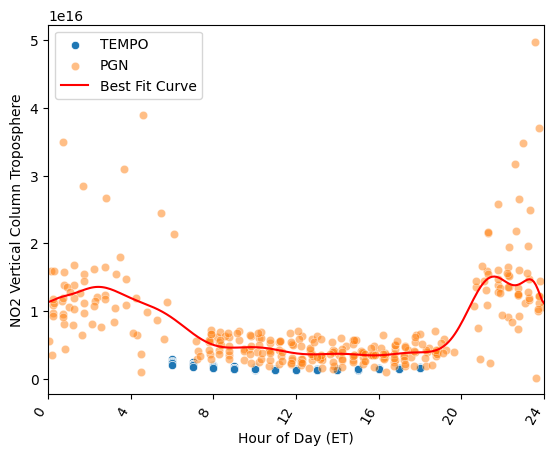

In [670]:
plot_cos = ['HourET', 'Time', 'Column']

fig, ax = plt.subplots()
plt.xticks(ticks=range(0, 25, 4), rotation=60, ha='right')
plt.xlim(0, 24)
plt.title = "TEMPO and PGN NO2 Vertical Column Troposphere vs Time of Day"
plt.xlabel('Hour of Day (ET)')
plt.ylabel("NO2 Vertical Column Troposphere")
sns.scatterplot(data=tempo_df, x='HourET', y='Column', label='TEMPO')
sns.scatterplot(data=pgn_df[['Column', 'HourET']].resample(timedelta(minutes=30)).mean(), x='HourET', y='Column', alpha=0.5, label='PGN')

# plot a best fit line for PGN (using an arbutrary high degree as overfitting doesn't matter for a best fit line)
degree = 20
coeffs = np.polyfit(pgn_df['HourET'], pgn_df.Column, degree)
x_fit = np.linspace(0, 24, 240)
y_fit = np.polyval(coeffs, x_fit)
ax = sns.lineplot(x=x_fit, y=y_fit, color='red', label=f'Best Fit Curve')

plt.legend=True

**Analysis**

Due to the scale of the PGN nightime variance, it can be hard to see the TEMPO daytime behaviour as anything more than a line.

When compared, it can be observed that TEMPO and PGN daytime day follow roughly the same pattern and that, although the nighttime data is much lower quality, a general trend exists.

## 3. Data Modeling

Frr now, only one column will be used but more could be easily added.

In [671]:
pgn_X_cols = ['TimeOfDay']
pgn_y_col = 'Column'

Rather than taking a random sample, we'll select one day to use as our test data and use the other 6 as our training data.

In [672]:
from sklearn.model_selection import train_test_split

test_df = pgn_df[pgn_df.index.date == datetime(2024, 7, 20).date()]
train_df = pgn_df[pgn_df.index.date != datetime(2024, 7, 20).date()]
print("Test day(s):")
for day in sorted(set(test_df.index.date)):
    print("\t-", day)
print("Train day(s):")
for day in sorted(set(train_df.index.date)):
    print("\t-", day)

X_train = train_df[pgn_X_cols]
y_train = train_df[pgn_y_col]
X_test  = test_df[pgn_X_cols]
y_test  = test_df[pgn_y_col]
print("Test Rows:", test_df.shape[0])
print("Train Rows:", train_df.shape[0])


Test day(s):
	- 2024-07-20
Train day(s):
	- 2024-07-15
	- 2024-07-16
	- 2024-07-17
	- 2024-07-18
	- 2024-07-19
	- 2024-07-21
	- 2024-07-22
	- 2024-07-23
	- 2024-07-24
Test Rows: 156
Train Rows: 893


### 3.1 Linear and Polynomial Regression

At first glance, the plot above looks like a 3rd order polynomail, lets try that model first.  Lets try plotting the results for a few different polynomial regression (which includes 1st order, or linear regression).

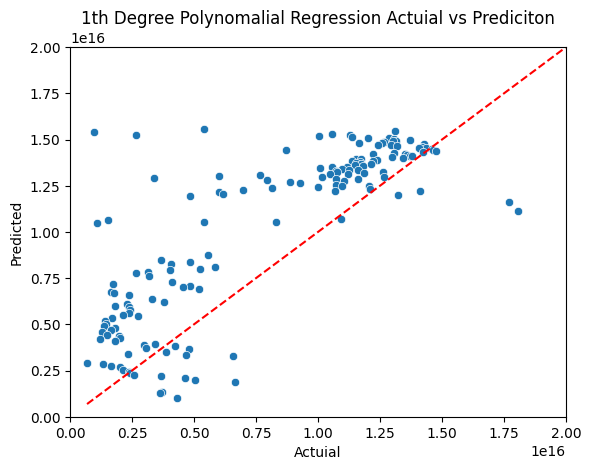

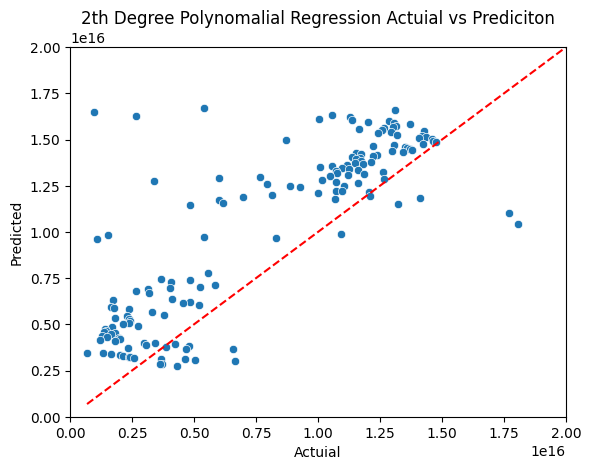

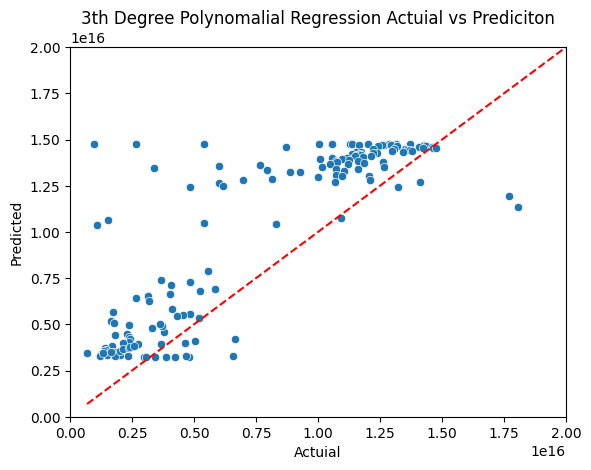

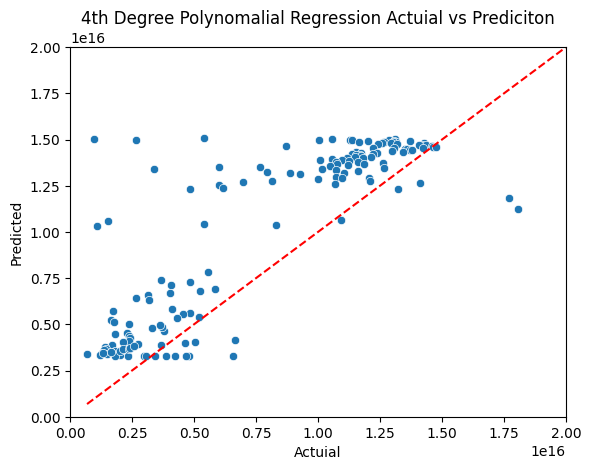

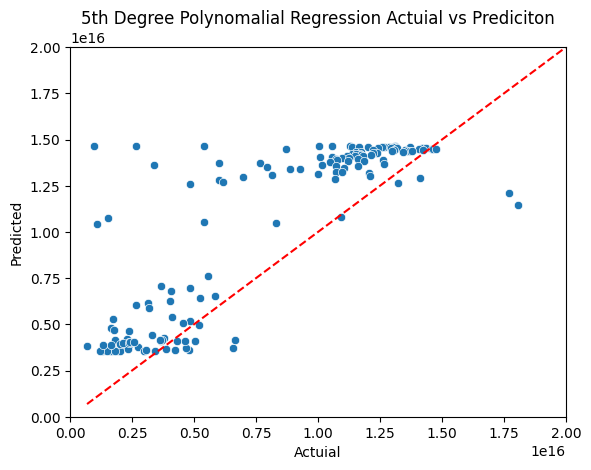

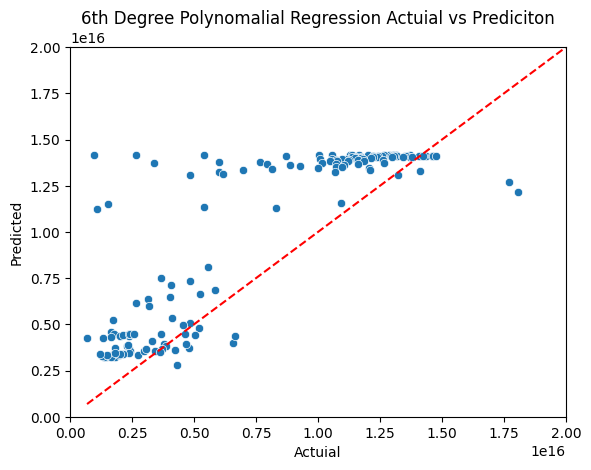

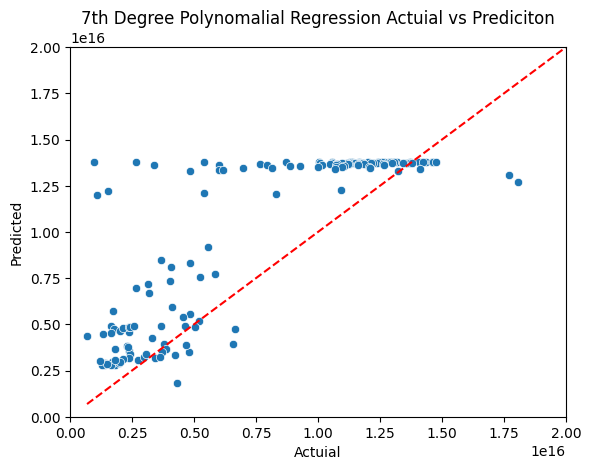

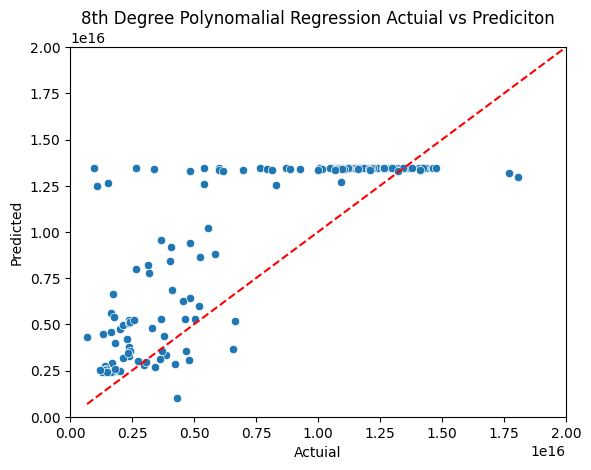

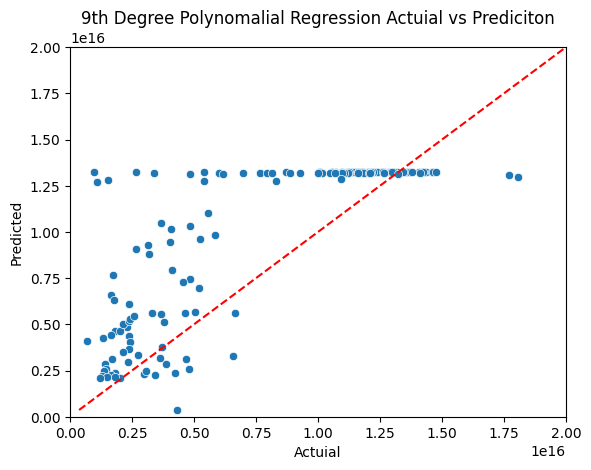

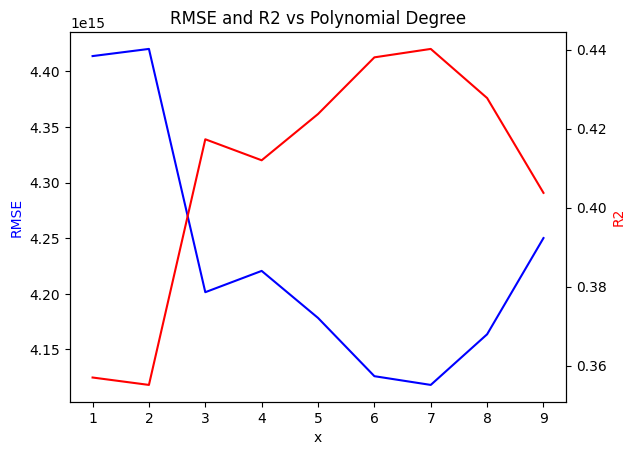

,index,Model,Degree,RMSE,R2
0,6,LinearRegression(),7,4.118155e+15,0.440200
1,5,LinearRegression(),6,4.126001e+15,0.438065
2,7,LinearRegression(),8,4.163659e+15,0.427761
3,4,LinearRegression(),5,4.178349e+15,0.423716
4,2,LinearRegression(),3,4.201473e+15,0.417320


In [673]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures


degrees = list(range(1, 10))
results = {'Model': [], 'Degree': [], 'RMSE': [], 'R2': []}
for i, degree in enumerate(range(1, 10)):

    # build a mdoel
    poly_transformer = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_transformer.fit_transform(X_train)
    model = LinearRegression()
    model.fit(X_poly, y_train)
    Y_pred = model.predict(X_poly)

    # get and score predictions
    X_test_poly = poly_transformer.fit_transform(X_test)
    y_pred = model.predict(X_test_poly)
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2 = r2_score(y_test, y_pred)

    results['Model'].append(model)
    results['Degree'].append(degree)
    results['RMSE'].append(rmse)
    results['R2'].append(r2)

    poly_transformer = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_transformer.fit_transform(X_test)
    y_pred = model.predict(X_poly)
    ax = sns.scatterplot(x=y_test, y=y_pred)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Prediction')
    ax.set_title(f"{degree}th Degree Polynomalial Regression Actuial vs Prediciton")
    ax.set_xlabel("Actuial")
    ax.set_ylabel("Predicted")
    ax.set_xlim(0, 2e16)
    ax.set_ylim(0, 2e16)
    plt.show()
regression_results = pd.DataFrame(results)
fig, ax1 = plt.subplots()
ax1.plot(regression_results.Degree,  regression_results.RMSE, label='RMSE', color='blue')
ax1.set_ylabel('RMSE', color='blue')
ax2 = ax1.twinx()
ax2.plot(regression_results.Degree, regression_results.R2, label='R2', color='red')
ax2.set_ylabel('R2', color='red')
ax1.set_xlabel('x')
ax1.set_title("RMSE and R2 vs Polynomial Degree")
plt.show()
ax.set_title("Polynomial Regression Degree vs RMSE")
ax.set_xlabel("Polynomial Regression Degree")
best_regression = regression_results.sort_values('RMSE').reset_index()
best_regression.head()

Analysis:

We can see that for each model, there are roughly two clusters, a lower and higher cluster.  It can also be seen that the higher degree polynomial models tend predict the same value regardless of the actual value which may result in a higher RMSE, but is undesireable and may be due to overfitting.

The 3rd order polynomial seems to be a good mix of fitting the data well while minimizing the RMSE.

Next, lets look at the ideal polynomial for each day and night, as they may differ.

Processing Day Cycle


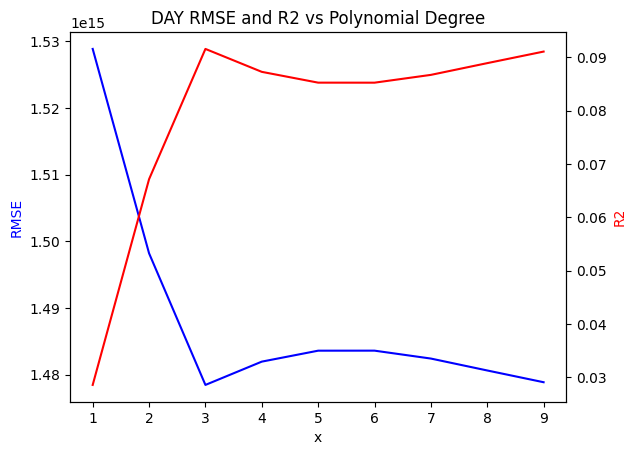

   index               Model  Degree          RMSE        R2
0      2  LinearRegression()       3  1.478457e+15  0.091570
1      8  LinearRegression()       9  1.478862e+15  0.091073
2      7  LinearRegression()       8  1.480626e+15  0.088904
3      3  LinearRegression()       4  1.481953e+15  0.087270
4      6  LinearRegression()       7  1.482414e+15  0.086702
Processing Night Cycle


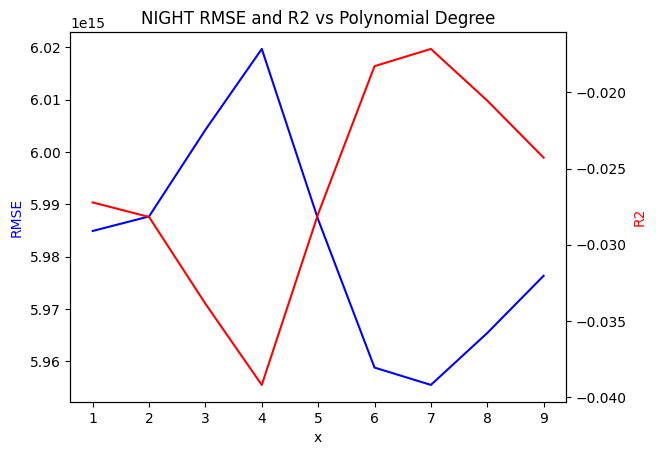

   index               Model  Degree          RMSE        R2
0      6  LinearRegression()       7  5.955442e+15 -0.017139
1      5  LinearRegression()       6  5.958761e+15 -0.018273
2      7  LinearRegression()       8  5.965367e+15 -0.020532
3      8  LinearRegression()       9  5.976313e+15 -0.024280
4      0  LinearRegression()       1  5.984888e+15 -0.027222


In [674]:
# use X to produce y
X_train_day, X_test_day, y_train_day, y_test_day = train_test_split(
    pgn_df[pgn_df.Cycle == "Day"][pgn_X_cols],
    pgn_df[pgn_df.Cycle == "Day"][pgn_y_col],
    test_size=0.2,
    random_state=42
)
X_train_night, X_test_night, y_train_night, y_test_night = train_test_split(
    pgn_df[pgn_df.Cycle == "Night"][pgn_X_cols],
    pgn_df[pgn_df.Cycle == "Night"][pgn_y_col],
    test_size=0.2,
    random_state=42
)

per_cycle_result = {}
for cycle, X_train, X_test, y_train, y_test in [
    ["Day", X_train_day, X_test_day, y_train_day, y_test_day],
    ["Night", X_train_night, X_test_night, y_train_night, y_test_night]
]:
    print("Processing", cycle, "Cycle")
    results = {'Model': [], 'Degree': [], 'RMSE': [], 'R2': []}
    for degree in degrees:
        # build a mdoel
        poly_transformer = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly = poly_transformer.fit_transform(X_train)
        model = LinearRegression()
        model.fit(X_poly, y_train)

        # get and score predictions
        X_test_poly = poly_transformer.fit_transform(X_test)
        y_pred = model.predict(X_test_poly)
        rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2 = r2_score(y_test, y_pred)

        results['Model'].append(model)
        results['Degree'].append(degree)
        results['RMSE'].append(rmse)
        results['R2'].append(r2)
    
    # plot it
    _regression_results = pd.DataFrame(results)
    fig, ax1 = plt.subplots()
    ax1.plot(_regression_results.Degree,  _regression_results.RMSE, label='RMSE', color='blue')
    ax1.set_ylabel('RMSE', color='blue')
    ax2 = ax1.twinx()
    ax2.plot(_regression_results.Degree, _regression_results.R2, label='R2', color='red')
    ax2.set_ylabel('R2', color='red')
    ax1.set_xlabel('x')
    ax1.set_title(f"{cycle.upper()} RMSE and R2 vs Polynomial Degree")
    plt.show()

    best_regression = _regression_results.sort_values('RMSE').reset_index()
    per_cycle_result[cycle] = best_regression
    print(best_regression.head())

It can be seen that a 3rd order describes daytime data well but high degree polynomials describe the nightime data better though as seen before, that may be attributed to overfitting.  For simplicity, I'll be assuming that a 3rd degree polynomail is the best choice.

**Future Work**
- Consider standardizing on a per cycle basis to correct for this.
- Consider centering the data by removing the mean.

### 3.2 Boosting Regression

#### 3.2.1 Scikit Learn GradientBoostingRegressor

First, we'll select a non-linear model and work with hyperparameters to maximize model performance.

NOTE: these hyperparameters were found through trial and error to same time.  Since estimators are farily cheap but data is sparce, I'm using a lot of estigators and a large leraning rate.

RMSE: 9.155589e+15
R2: -1.40


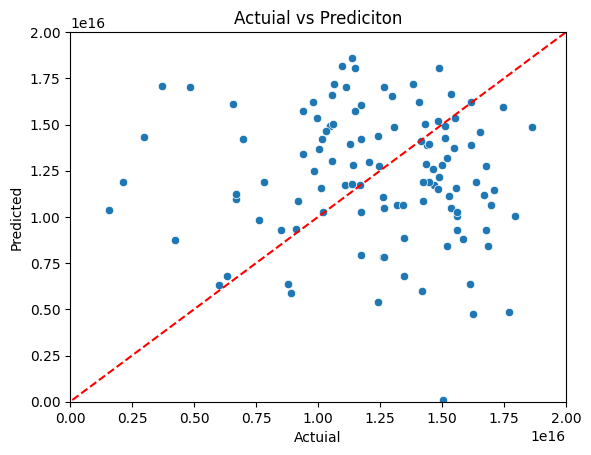

In [675]:
from itertools import product

from sklearn.ensemble import GradientBoostingRegressor

results = {'Model': [], 'Estimators': [], 'Rate': [], 'Depth': [], 'RMSE': []}
# build model
gbr = GradientBoostingRegressor(
    n_estimators=10_000,
    learning_rate=0.5,
    max_depth=5,
    random_state=42
)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)

# plot results
y_pred = gbr.predict(X_test)
ax = sns.scatterplot(x=y_test, y=y_pred)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Prediction')
ax.set_title("Actuial vs Prediciton")
ax.set_xlabel("Actuial")
ax.set_ylabel("Predicted")
ax.set_xlim(0, 2e16)
ax.set_ylim(0, 2e16)
print(f"RMSE: {rmse:e}")
print(f"R2: {r2:.2f}")

Analysis: 
- There's room to tune hyperparameters more, but it seems that in terms of fitting the actuial data and RMSE, gradient boosting regression underperforms.
- There's a chance that this might perform better with larger datasets as it may have a hard time learning with such a small dataset.

### 3.3 Ridge Regression

Ridge regression should handle noice better, which may help for nighttime modeling and create a more general model.

RMSE: 5.984888e+15
R2: -0.03


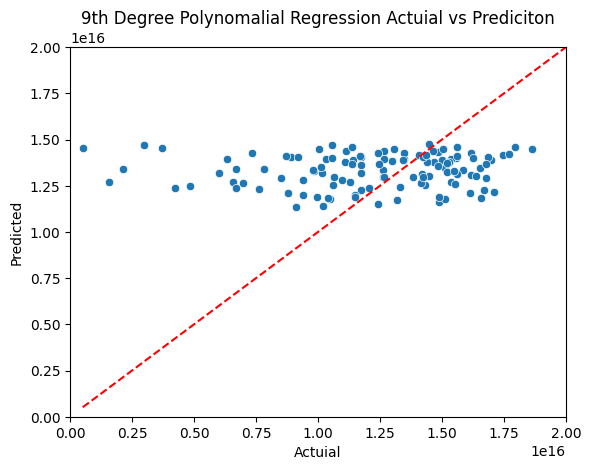

In [676]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train, y_train)

# get and score predictions
y_pred = model.predict(X_test)
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:e}")
print(f"R2: {r2:.2f}")

# plot performance
ax = sns.scatterplot(x=y_test, y=y_pred)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Prediction')
ax.set_title(f"{degree}th Degree Polynomalial Regression Actuial vs Prediciton")
ax.set_xlabel("Actuial")
ax.set_ylabel("Predicted")
ax.set_xlim(0, 2e16)
ax.set_ylim(0, 2e16)
plt.show()

Analysis:
- Ridge regression appears to guess similar values regardless of the actual value, this could mean that it's model isn't a high enough order function to capture the data.
- Polynomial ridge regression could be used to explore improving ridge regressions results.
- Since polynomial regression performs significantly better, I won't eplore ridge regresion further.

### Random Forest Regression

Next lets try random forest regression, another non-linear model.

In [677]:
from sklearn.ensemble import RandomForestRegressor


results = {'Model': [], 'Estimators': [], 'Depth': [], 'RMSE': [], 'R2': []}
estimators = [10, 100, 1_000]
depths = [10, 20, 40, 80]
for e, d in product(estimators, depths):
    # build model
    gbr = RandomForestRegressor(
        n_estimators=e,       # number of boosting stages
        max_depth=d,          # depth of each tree
        random_state=42
    )
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2 = r2_score(y_test, y_pred)
    results['Model'].append(gbr)
    results['Estimators'].append(e)
    results['Depth'].append(d)
    results['RMSE'].append(rmse)
    results['R2'].append(r2)
results = pd.DataFrame(results)
print("Sorted by RMSE")
print(results.sort_values('RMSE')[['Estimators', 'Depth', 'RMSE', 'R2']].reset_index().head())
print("Sorted by R2")
print(results.sort_values('R2')[['Estimators', 'Depth', 'RMSE', 'R2']].reset_index().head())

Sorted by RMSE
   index  Estimators  Depth          RMSE        R2
0      0          10     10  7.051463e+15 -0.425971
1      4         100     10  7.472462e+15 -0.601326
2      1          10     20  7.535020e+15 -0.628250
3      2          10     40  7.544839e+15 -0.632496
4      3          10     80  7.544839e+15 -0.632496
Sorted by R2
   index  Estimators  Depth          RMSE        R2
0     10        1000     40  8.076955e+15 -0.870887
1     11        1000     80  8.076955e+15 -0.870887
2      9        1000     20  8.068802e+15 -0.867112
3      6         100     40  7.982292e+15 -0.827290
4      7         100     80  7.982292e+15 -0.827290


Analysis:
- Without plotting the actuial vs the prediction data, it can be seen that Random Forest falls far behind polynomial regression and won't be explored further.

## 4. Model Application

Polynomial regression performs the best which has a nice side effect of providing a reusable polynomial equations which can be used for predicting.  

Assumptions
- The intercept of the polynomial is being set by the linear, daytime data.
- The nighttime NO2 curve is being set by the model coefficents.

Hypothesis
- TEMPO can be used to define an intercept which, which combined iwth the mdoel coefficents will create a usable model.

NOTE: This notebook dose not intend to prove the hypothesis above, but instead uses it as a tool to direct the upcomming analysis.  A proper hypothesis test can be conducted at a later date if there's enough value.

In [ ]:
tempo_test_df = tempo_df[tempo_df.index.date == datetime(2024, 7, 20).date()].dropna()
tempo_mean = tempo_test_df.Column.mean()
print(f"Tempo Intercept: {tempo_mean:e}")
tempo_test_df.head()

Tempo Intercept: 1.681227e+15


,Latitude,Longitude,Column,Uncertainty,TimeOfDay,MinOfDay,HourOfDay,HourET
Time,,,,,,,,
2024-07-20 10:00:00,41.260361,-76.646950,2.423323e+15,1.102959e+15,36000.0,600.0,10.0,6.0
2024-07-20 11:00:00,34.294022,-78.301735,2.147304e+15,1.090298e+15,39600.0,660.0,11.0,7.0
2024-07-20 12:00:00,34.162636,-78.337234,1.890977e+15,1.210283e+15,43200.0,720.0,12.0,8.0
2024-07-20 13:00:00,34.167969,-78.357185,1.662014e+15,1.258135e+15,46800.0,780.0,13.0,9.0
2024-07-20 14:00:00,34.243629,-78.423950,1.562212e+15,1.287226e+15,50400.0,840.0,14.0,10.0


Next, I'll build an equation for y.

Text(0, 0.5, 'NO2 Vertical Column Troposphere')

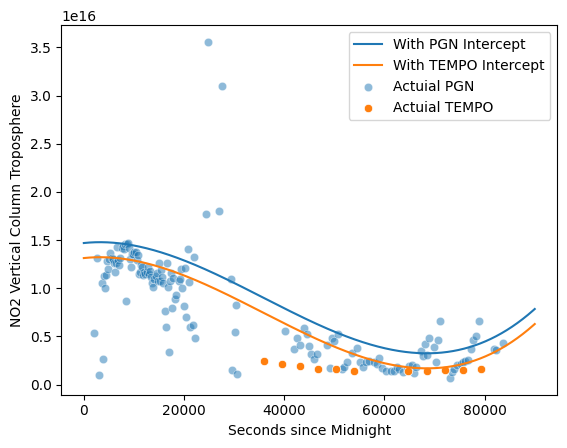

In [679]:
degree = 3
best_model = regression_results[regression_results.Degree == degree].iloc[0]
coefs = best_model.Model.coef_

# get the offset: 
#   we don't know exacly where the curve should be centered
#   but we know that the daytime values should be near the bottom
#   so we'll get the minimum value of the curve and add it to the tempo_mean.
center_predict = lambda x: coefs[0]*(x**1) + coefs[1]*(x**2) + coefs[2]*(x**3)
min_y = min(map(center_predict, range(1, 25*60*60)))
tempo_intercept = tempo_mean - min_y

y_predict_pgn = lambda x: best_model.Model.intercept_ + coefs[0]*(x**1) + coefs[1]*(x**2) + coefs[2]*(x**3)
y_predict_tempo = lambda x: tempo_intercept + coefs[0]*(x**1) + coefs[1]*(x**2) + coefs[2]*(x**3)


# first lets show the model
x = list(range(1, 25*60*60))
y_pred = list(map(y_predict_pgn, x))
ax = sns.lineplot(x=x, y=y_pred, label="With PGN Intercept")

# first lets show the model
x = list(range(1, 25*60*60))
y_pred = list(map(y_predict_tempo, x))
ax = sns.lineplot(x=x, y=y_pred, label="With TEMPO Intercept")

# now lets show the actuial values
x = test_df.TimeOfDay
y = test_df.Column
sns.scatterplot(ax=ax, x=x, y=y, label="Actuial PGN", alpha=0.5)

# now lets show the actuial values
x = tempo_test_df.TimeOfDay
y = tempo_test_df.Column
sns.scatterplot(ax=ax, x=x, y=y, label="Actuial TEMPO")

plt.title = "3rd Degree Polynomial Model with TEMPO Intercept vs Time of Day"
plt.xlabel('Seconds since Midnight')
plt.ylabel("NO2 Vertical Column Troposphere")

Analysis:
- Unfortunatly, using the TEMPO mean to calculate an intersect does nto appear to improve performance and make negative predictions which cannot be correct.  It appears that the PGN coefficents cannt simply be applied to the TEMPO data.
- Using the models built in intercept, it appears that the model provides a fairly good prediction of the PGN readings.
- Using the mdoels built in intercept, it appears that the model does not do a good job of describing TMEPO readings.
- Since one model cannot be used to describe both sets of NO2 readings for the same day, it cannot be assuemd that this model can be used to predict nighttime NO2 data from TEMPO alone, without additional work.